In [651]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tqdm.notebook import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, RepeatVector, MaxPooling2D, Conv2D, Concatenate, UpSampling2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMaker import *

In [32]:
LATENT_DIM = 128
BASE_DEPTH = 8
CHANNELS = 5
IMAGE_SHAPE = (CHANNELS, 64, 64)
BATCH_SIZE = 32 * 10
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-2

In [33]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [34]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing.hdf5'

gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape) # a batch of images
print(train_gen[0][1].shape) # a batch of corresponding redshifts

(320, 5, 64, 64)
(320,)


In [35]:
batch_count = 0
def next_batch():
    global batch_count
    train_set = train_gen[batch_count]
    x_train = np.asarray(train_set[0])
    y_train = train_set[1]
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [652]:
def build_generator(LATENT_DIM):
    noise = Input(shape = (LATENT_DIM,))
    label = Input(shape = (1,), dtype = 'float32')
    label_embedding = Dense(LATENT_DIM)(label)
    model_input = Concatenate()([noise, label_embedding])
    
    x = Dense(512, activation = "relu", kernel_regularizer = l2(0.001))(model_input)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = "relu", kernel_regularizer = l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(128 * 16 * 16 + 64 * 16 * 16 + 32 * 32 * 32, activation = "relu")(x)
    dense1, dense2, dense3 = tf.split(x, [128 * 16 * 16, 64 * 16 * 16, 32 * 32 * 32], axis = 1)
    reshape1 = Reshape((128, 16, 16))(dense1)
    reshape2 = Reshape((64, 16, 16))(dense2)
    reshape3 = Reshape((32, 32, 32))(dense3)
    up1 = UpSampling2D(size = (2, 2), data_format = 'channels_first')(reshape1)
    conv1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', data_format = 'channels_first')(up1)
    up2 = UpSampling2D(size = (2, 2), data_format = 'channels_first')(reshape2)
    conv2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', data_format = 'channels_first')(up2 + conv1)
    up3 = UpSampling2D(size = (2, 2), data_format = 'channels_first')(reshape3 + conv2)
    conv3 = Conv2D(5, (3, 3), activation = 'relu', padding = 'same', data_format = 'channels_first')(up3)

    outputs = Reshape(IMAGE_SHAPE)(conv3)
    
    model = Model([noise, label], outputs)
    return model

In [653]:
def minibatch_discrimination(x, B, C):
    ''' Minibatch discrimination layer
        x: tensor, input feature vectors
        B & C: int, dimensions of the tensor T
    '''
    T = Dense(B * C, kernel_initializer = 'glorot_uniform')(x)  # Step 1
    T = Reshape((B, C))(T)
    
    diffs = K.expand_dims(T, 3) - K.expand_dims(K.permute_dimensions(T, [1, 2, 0]), 0)
    abs_diffs = K.sum(K.abs(diffs), axis = 2)
    
    mb_disc = K.sum(K.exp(-abs_diffs), axis = 2)  # Step 3
    
    return mb_disc

In [654]:
def build_discriminator(IMAGE_SHAPE):
    img = Input(shape = IMAGE_SHAPE)
    label = Input(shape = (1,), dtype = 'float32')

    label_embedding = Dense(np.prod(IMAGE_SHAPE))(label)
    label_embedding = Reshape(IMAGE_SHAPE)(label_embedding)
    
    merged_input = Concatenate(axis = 1)([img, label_embedding]) # Concatenate along channels

    conv1 = Conv2D(32, 3, strides = 2, padding = 'same', data_format = 'channels_first')(merged_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha = 0.2)(conv1)
    conv2 = Conv2D(64, 3, strides = 2, padding = 'same', data_format = 'channels_first')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha = 0.2)(conv2)
    conv3 = Conv2D(128, 2, strides = 1, padding = 'same', data_format = 'channels_first')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha = 0.2)(conv3)
    
    flatten1 = Flatten()(conv1)
    flatten2 = Flatten()(conv2)
    flatten3 = Flatten()(conv3)
    # mb_disc = minibatch_discrimination(flatten3, B = 100, C = 5)
    concat = Concatenate()([flatten1, flatten2, flatten3])

    x = Dense(512, activation = "relu")(concat)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = Model([img, label], outputs)
    return model

In [699]:
class CustomDiscriminator(tf.keras.Model):
    def __init__(self, discriminator_model):
        super(CustomDiscriminator, self).__init__()
        self.discriminator = discriminator_model

    def call(self, inputs, training = None, mask = None):
        return self.discriminator(inputs)

    def compile(self, optimizer, discriminator_loss_fn):
        super(CustomDiscriminator, self).compile()
        self.optimizer = optimizer
        self.discriminator_loss_fn = discriminator_loss_fn

    def train_step(self, data):
        # Unpack the data
        (images, redshifts), labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            preds = self.discriminator([images, redshifts])

            # Compute the loss value
            # (the loss function is configured in `compile`)
            loss = self.discriminator_loss_fn(labels, preds, images)

        # Compute gradients
        trainable_vars = self.discriminator.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Return a dict mapping metric names to current value
        return {"loss": loss}

In [700]:
def calculate_pairwise_distances(batch_images):
    # Reshape images to vectors for simpler distance calculation
    image_vectors = tf.reshape(batch_images, (tf.shape(batch_images)[0], -1))
    
    # Calculate pairwise distances
    r = tf.reduce_sum(image_vectors * image_vectors, axis = 1, keepdims = True)
    distances = r - 2 * tf.matmul(image_vectors, tf.transpose(image_vectors)) + tf.transpose(r)
    
    return distances

In [787]:
def discriminator_loss(y_true, y_pred, batch_images):
    # Original loss (e.g., binary cross-entropy)
    original_loss = binary_crossentropy(y_true, y_pred)
    
    # Calculate pairwise distances in batch (simplified)
    # You can use more complex methods
    distances = calculate_pairwise_distances(batch_images)
    
    # Create a uniqueness penalty term
    uniqueness_penalty = K.sum(K.exp(-distances))
    
    # Add penalty term to original loss
    total_loss = original_loss + 0.1 * uniqueness_penalty
    
    return total_loss

In [788]:
def build_gan(generator, discriminator):
    
    # discriminator.compile(optimizer = Adam(learning_rate = 0.0001), loss = discriminator_loss, metrics = ['accuracy'])
    
    discriminator.compile(optimizer = tf.keras.optimizers.Adam(), discriminator_loss_fn = discriminator_loss)
    
    discriminator.trainable = False
    
    noise = Input(shape = (LATENT_DIM,))
    label = Input(shape = (1,))
    img = generator([noise, label])
    fake_pred = discriminator([img, label])

    combined_model = Model([noise, label], fake_pred)
    combined_model.compile(optimizer = Adam(learning_rate = 0.00005), loss = 'binary_crossentropy')
    return combined_model

In [789]:
generator = build_generator(LATENT_DIM)

# discriminator = build_discriminator(IMAGE_SHAPE) # Your original function
discriminator_model = build_discriminator(IMAGE_SHAPE) # Your original function
discriminator = CustomDiscriminator(discriminator_model)


gan = build_gan(generator, discriminator)

In [790]:
generator.summary()
discriminator.summary()

Model: "model_111"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_234 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_233 (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 dense_311 (Dense)              (None, 128)          256         ['input_234[0][0]']              
                                                                                                  
 concatenate_117 (Concatenate)  (None, 256)          0           ['input_233[0][0]',              
                                                                  'dense_311[0][0]']      

  0%|          | 0/10 [00:00<?, ?it/s]

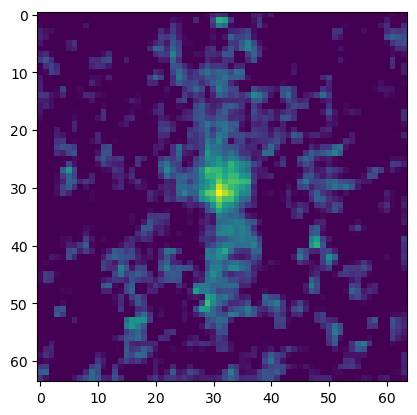

In [807]:
epochs = 10

for epoch in tqdm(range(epochs)):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1))
    
    fake_labels = np.ones((BATCH_SIZE, 1)) * 0.1
    indices_to_change = np.random.choice(BATCH_SIZE, size = int(0.20 * BATCH_SIZE), replace = False)
    fake_labels[indices_to_change] = 0.1
    
    fake_images = generator.predict([noise, fake_redshift], verbose = 0)
    
    # print(fake_images.shape)
    
    real_images, real_redshift = next_batch() # Get a batch of real images
    real_redshift = np.expand_dims(real_redshift, axis = 1)
    
    real_labels = np.ones((BATCH_SIZE, 1)) * 0.9
    indices_to_change = np.random.choice(BATCH_SIZE, size = int(0.20 * BATCH_SIZE), replace = False)
    real_labels[indices_to_change] = 0.1
    
    # print(real_images.shape)
    
    labels = np.vstack([real_labels, fake_labels])
    # print(real_redshift.shape)
    # print(fake_redshift.shape)
    redshifts = np.vstack([real_redshift, fake_redshift])
    # print(real_images.shape)
    # print(fake_images.shape)
    images = np.vstack([real_images, fake_images])
    
    # print(images.shape)
    
    d_loss = discriminator.fit([images, redshifts], labels, batch_size = 32, epochs = 10, shuffle = True, verbose = 0)
    
    real_labels = np.ones((BATCH_SIZE, 1)) * 0.9
    indices_to_change = np.random.choice(BATCH_SIZE, size = int(0.50 * BATCH_SIZE), replace = False)
    real_labels[indices_to_change] = 0.1
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1)) # a vector of fake redshift to input the generator
    g_loss = gan.fit([noise, fake_redshift], real_labels, batch_size = 64, epochs = 1, shuffle = True, verbose = 0) # train the generator
    
    # print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
        
plt.imshow(fake_images[0][4])

In [792]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [13]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/64x64/5x64x64_gan_generated.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(1999)):
    z = random.uniform(0, 4)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

NameError: name 'prior' is not defined

In [804]:
fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1))
noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
fake_labels = np.zeros((BATCH_SIZE, 1))
fake_images = generator.predict([noise, fake_redshift])

10/10 [==============================] - 0s 2ms/step


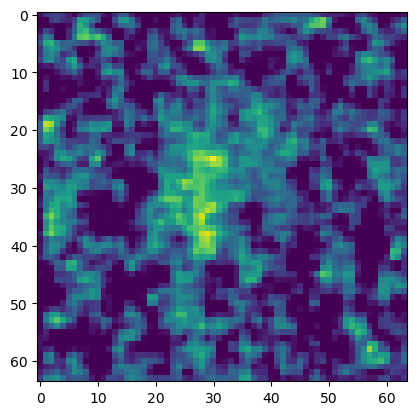

In [805]:
plt.imshow(fake_images[35][4])

In [ ]:
print(discriminator([fake_images, fake_redshift]))

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
stop here

In [ ]:
model_name = 'gan'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

In [ ]:
gan.save_weights(weights_path)

In [ ]:
gan.load_weights(weights_path)

In [ ]:
model_name = 'discriminator'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

In [ ]:
discriminator.save_weights(weights_path)

In [ ]:
discriminator.load_weights(weights_path)

In [ ]:
# END